### taufit

 Simulate and fit a DRW light curve

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from multiprocessing import Pool
from itertools import repeat

Import package methods to simulate and fit DRW

In [94]:
import taufit
import importlib
importlib.reload(taufit)

<module 'taufit' from '/home/s1/cburke/taufit/taufit.py'>

In [95]:
from taufit import simulate_drw
from taufit import fit_drw

Generate simualted light curve with 6 seasons

In [96]:
num_seasons = 6
season_duration = 120 # days
cadence = 7 # days
x = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
x = np.array(x).flatten()

Define function to simulate DRW light curves with similar amplitude fluctuations at a given timescale, typical mean magnitude, and error bars, with Gaussian white noise.

In [97]:
def simulate_and_fit_drw(x, log_tau_drw, sigma_hat=0.2, ymean=20, ysigma=0.02, plot=False, verbose=False):
    tau = 10**log_tau_drw
    # Change SFinf to display similar amplitude fluctuations at a given timescale
    SFinf = sigma_hat*np.sqrt(tau/250)
    # Simulate and fit DRW
    y = simulate_drw(x, xmean=ymean, tau=tau, SFinf=SFinf)
    yerr = [ysigma]*len(y)
    # Add RMS fluctuations
    y += np.random.normal(0,ysigma)
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x*u.day, y*u.mag, yerr*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered = np.log10(1/np.exp(np.median(samples[:,1])))
    return log_tau_drw, log_tau_drw_recovered

Simulate $\tau_{\rm{DRW}}=250$ days:

Initial log-likelihood: 64.63768214815624
Final log-likelihood: 158.99726766318253
Running burn-in...
Running production...


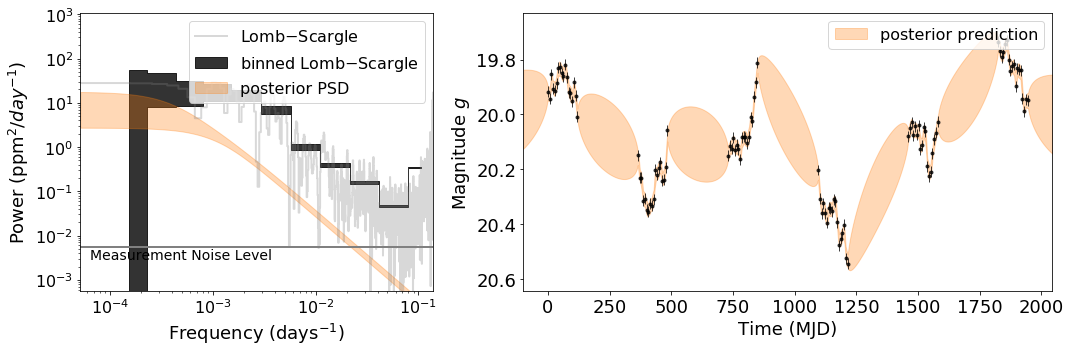

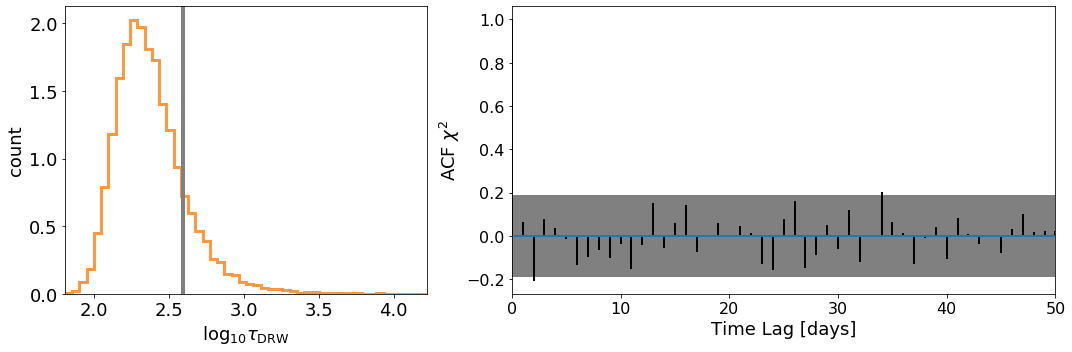

(2.3979400086720375, 2.3401500441385377)

In [98]:
simulate_and_fit_drw(x, np.log10(250), plot=True, verbose=True)

Simulate $\tau_{\rm{DRW}}=2500$ days:

Initial log-likelihood: 64.88761844335275
Final log-likelihood: 163.33986053930647
Running burn-in...
Running production...


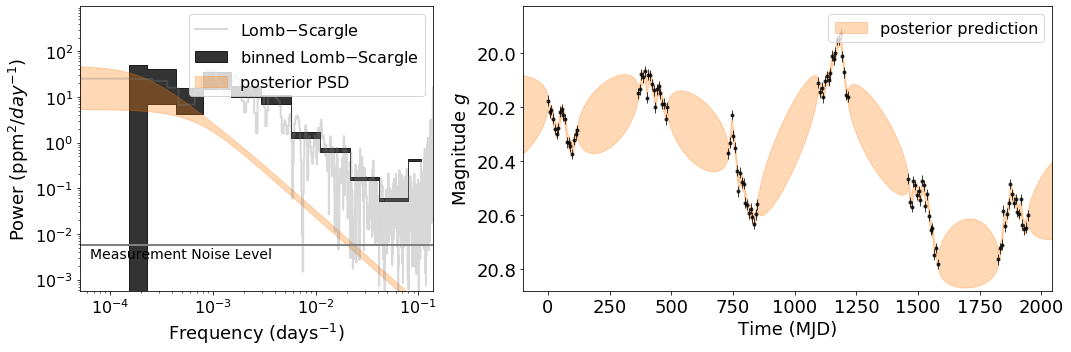

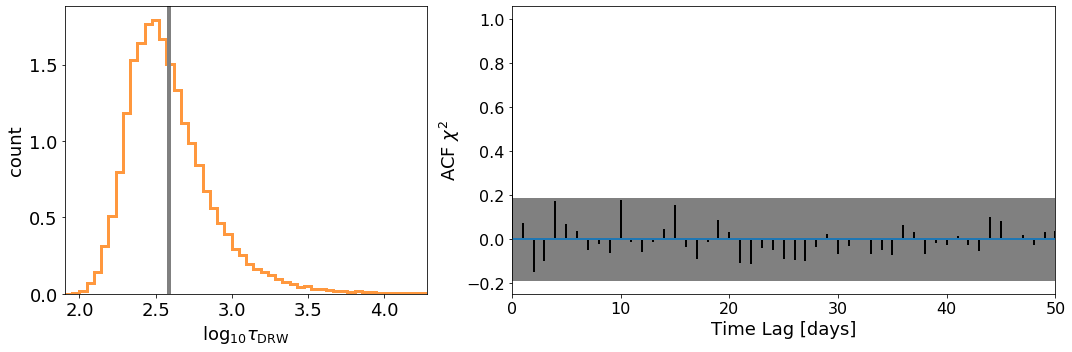

(3.3979400086720375, 2.5427376874765053)

In [99]:
simulate_and_fit_drw(x, np.log10(2500), plot=True, verbose=True)

### Assess bias in the fitting

Generate random DRW light curves with a range of input $\tau_{DRW}$ and see how well we can recover the input.

You may want can togggle whether you would like to plot the output or not by change the default arugment in `simulate_and_fit_drw` above.

In [100]:
# Generate input taus
#x = np.arange(0,2000,7)
log_tau_drw_true = np.linspace(1, 5, 20*20)
# Use multiprocessing to pool each fitting to a simualted light curve
pool = Pool(20)
args = zip([x]*len(log_tau_drw_true), log_tau_drw_true)
taus = pool.starmap(simulate_and_fit_drw, args)
pool.close()
pool.join()
taus = np.array(taus)

### Plot the results

Plot input $\tau_{\rm{DRW}}$ vs. output $\tau_{\rm{DRW}}$. Note the confirmation of the bias reported by [Kozlowski (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.128K/abstract) when the input $\tau_{\rm{DRW}}$ approaches 20% of the light curve baseline. 

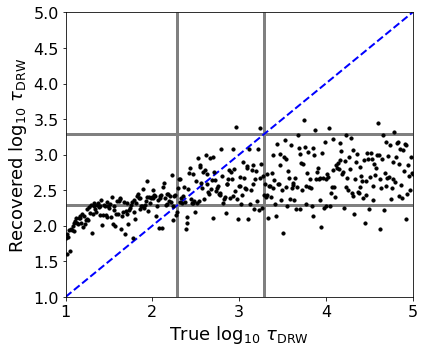

In [101]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.scatter(taus[:,0], taus[:,1], s=10, c='k')
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.plot([1,5],[1,5], lw=2, color='b', zorder=-1, linestyle='dashed')
ax.tick_params('both',labelsize=16)
ax.set_xlabel(r'True $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
ax.set_ylabel(r'Recovered $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
#ax.legend(fontsize=16, loc=2)
# vertical lines at cadence (7 days) and baseline.
baseline = np.max(x) - np.min(x)
ax.vlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.vlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)

fig.tight_layout()